In [1]:
import sys
sys.path.append('../..')

In [2]:
import dgl
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pickle 

from dgl import DGLGraph
from utils.dataset import Dataset
from torch.nn.utils import clip_grad_norm_
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from reaction_predictors.graph_model.models import RGCNNClassifier
from utils.graph_utils import get_bonds, get_nodes, get_graph

In [3]:
def batch_gen(batch_size, dataset, device='cuda'):
    idxs = np.random.randint(0, len(dataset.dataset), batch_size)
    graphs = []
    targets = []
    for idx in idxs:
        g, target = get_graph(dataset, idx, bond2label, node2label, pad_length=pad_length, device=device)
        targets.append(target)
        graphs.append(g)
    graphs = dgl.batch(graphs)
    targets = torch.from_numpy(np.stack(targets)).to(device).float()
    return graphs, targets

In [4]:
def get_scores(tgts, predict):
    p, r, f, fm = [], [], [], []
    for t, pr in zip(tgts, predict):
        p_, r_, f_, _ =  precision_recall_fscore_support(t[t>-.1], pr[t>-.1], average='binary')
        p.append(p_)
        r.append(r_)
        f.append(f_)
    return p, r, f

In [5]:
train_dataset = pickle.load(open('../../data/train_dataset_50.pkl', 'rb'))
test_dataset = pickle.load(open('../../data/test_dataset_50.pkl', 'rb'))

In [6]:
n_molecule_level=1
n_reaction_level=1
node2label = get_nodes([train_dataset, test_dataset], n_molecule_level=n_molecule_level, n_reaction_level=n_reaction_level)
bond2label = get_bonds([train_dataset, test_dataset], n_molecule_level=n_molecule_level, n_reaction_level=n_reaction_level, self_bond=True)

In [12]:
bond2label['TRIPLE'] = 0
bond2label['SINGLE'] = 0
bond2label['DOUBLE'] = 0
bond2label['SELF'] = 1
bond2label['ML_0'] = 2
bond2label['RL_(0, 0)'] = 3

In [13]:
device='cuda:1'
max_num_atoms = 50
self_bond = True
pad_length = max_num_atoms + 15*n_molecule_level + n_molecule_level*n_reaction_level 
batch_size = 64
num_nodes = pad_length
num_rels = 4
n_hidden = 64
lr = 1e-3
num_conv_layers=4
num_fcn_layers=2

In [14]:
model = RGCNNClassifier(len(node2label),
              num_nodes,
              batch_size,
              n_hidden,
              num_rels, 
              num_conv_layers, 
              num_fcn_layers
             )
model = model.to(device)
optimizer =  torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

In [15]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [16]:
sigmoid = nn.Sigmoid()
bce_loss = nn.BCELoss()

In [17]:
train_pr_avg = []
train_re_avg = []
train_fs_avg = []
test_pr_avg = []
test_re_avg = []
test_fs_avg = []
train_fm_avg = []
test_fm_avg = []

In [18]:
def exp_lr_scheduler(optimizer, global_step, init_lr=1e-3, decay_steps=2000, decay_rate=.9):
    lr = init_lr * decay_rate**(global_step // decay_steps)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

/home/socrates/miniconda3/envs/chem/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


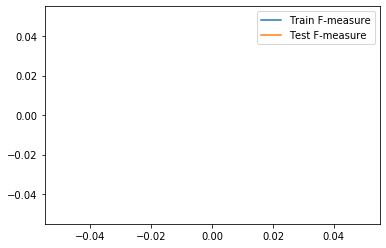

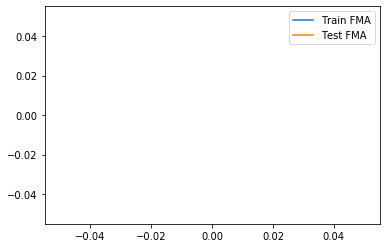

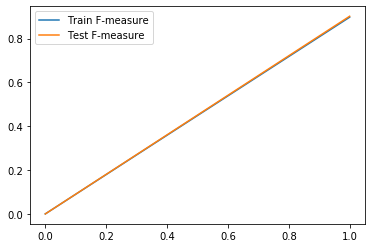

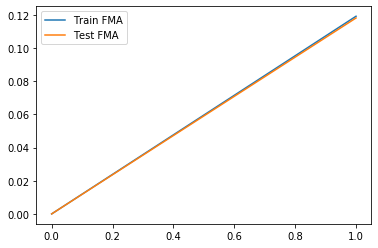

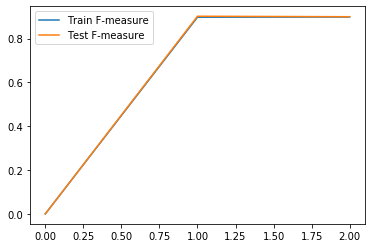

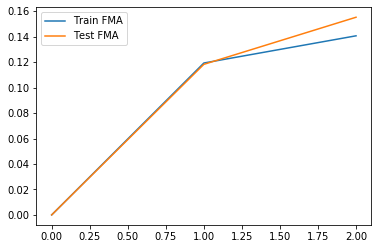

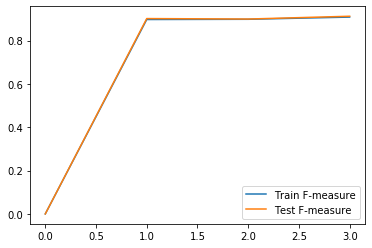

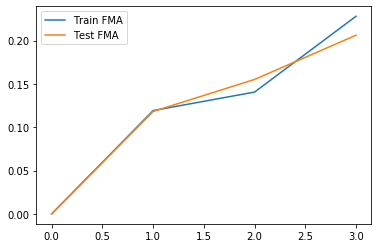

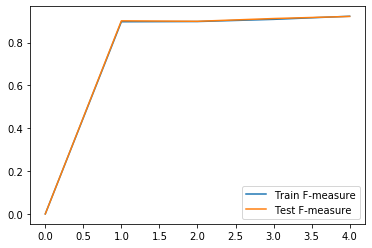

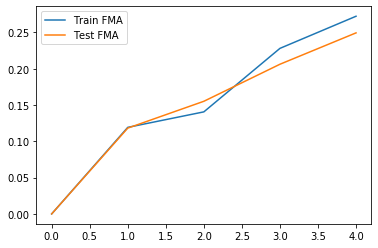

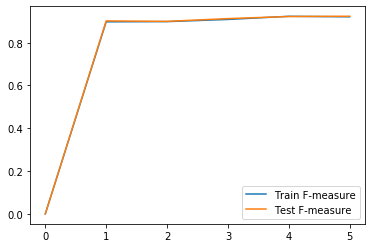

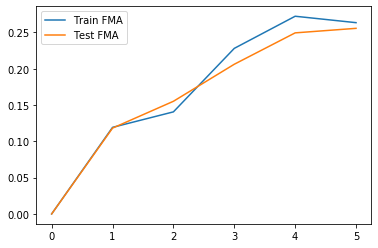

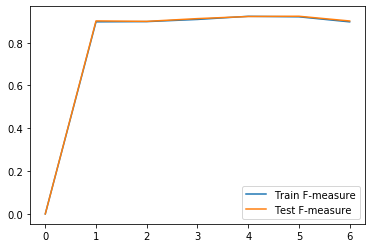

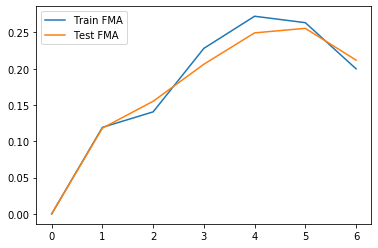

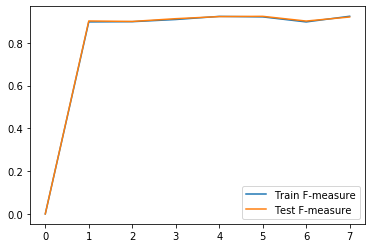

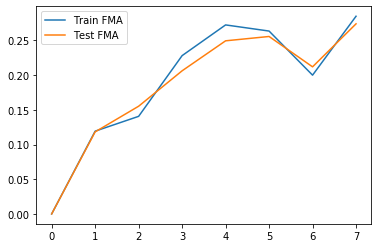

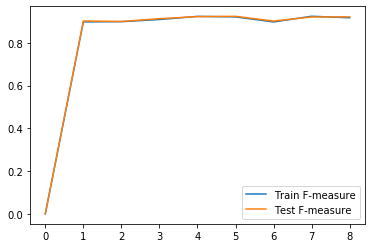

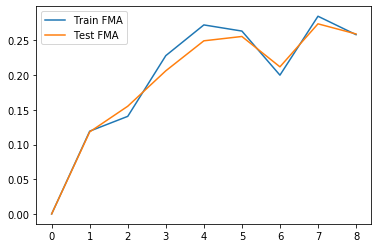

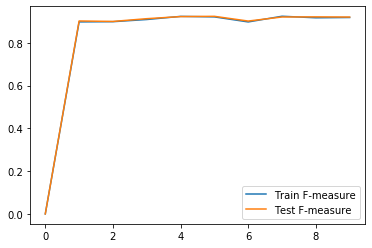

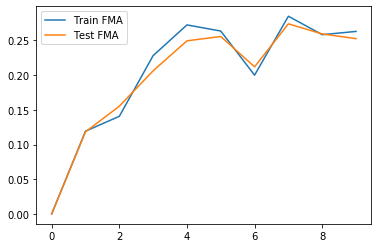

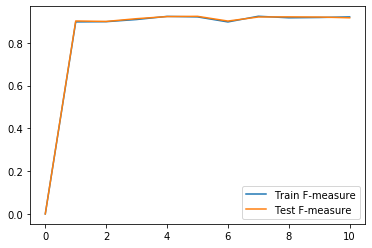

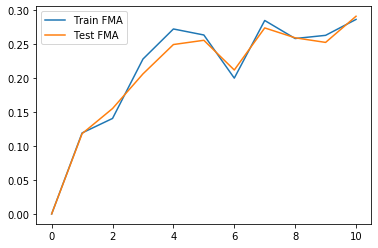

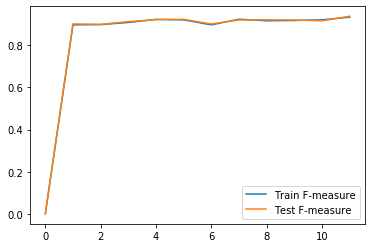

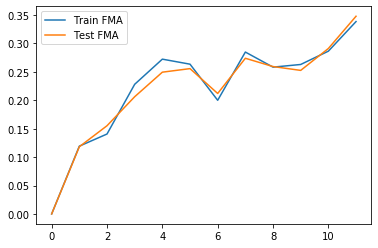

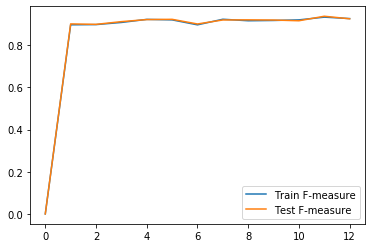

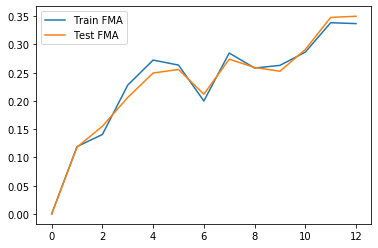

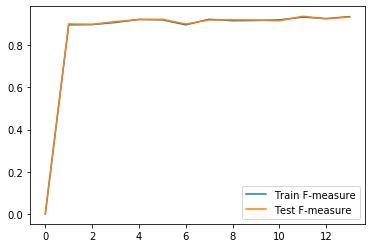

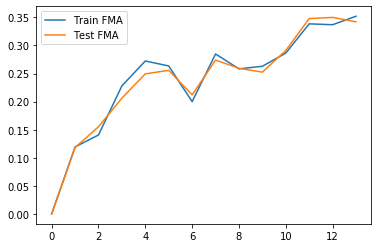

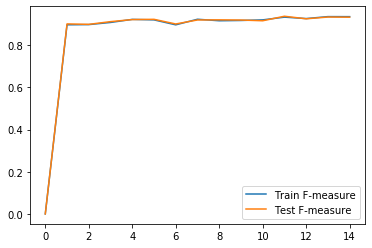

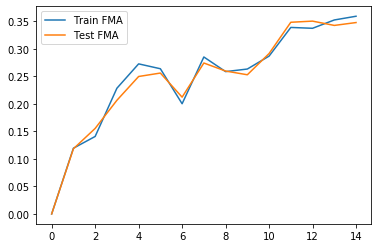

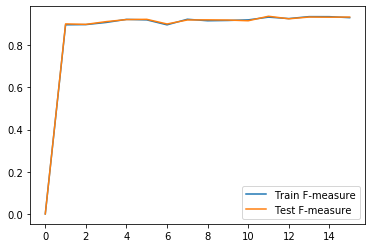

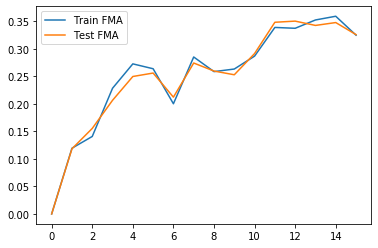

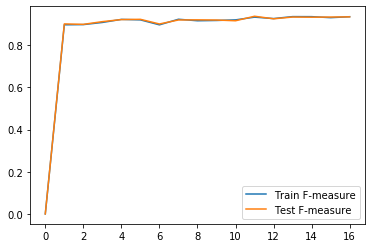

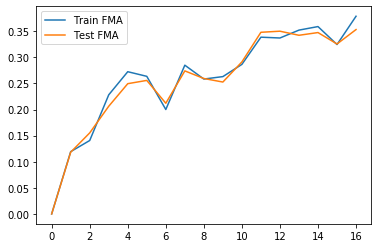

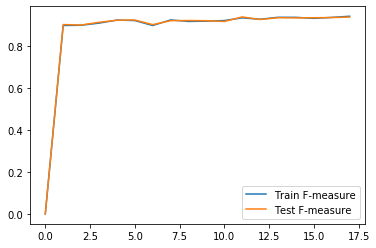

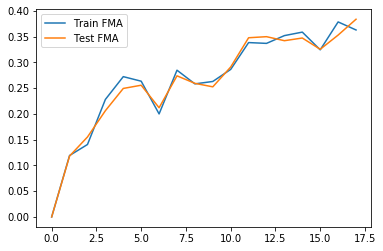

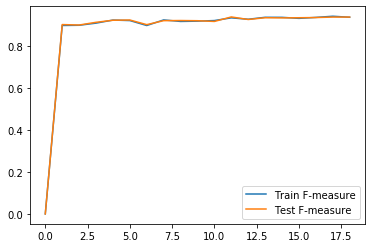

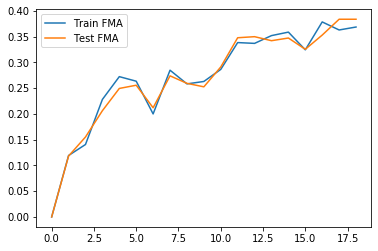

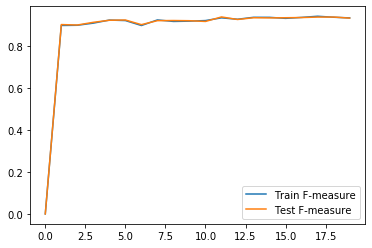

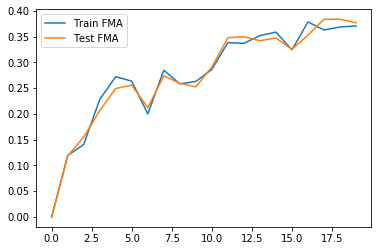

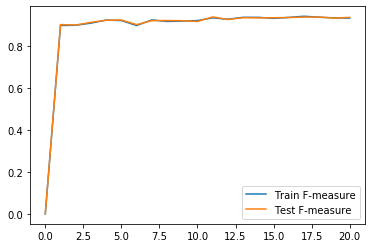

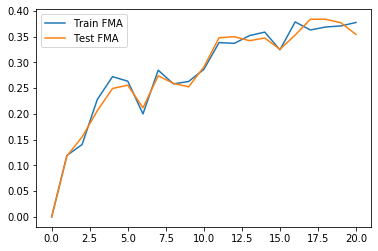

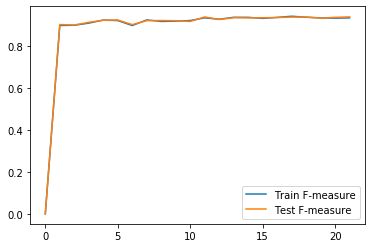

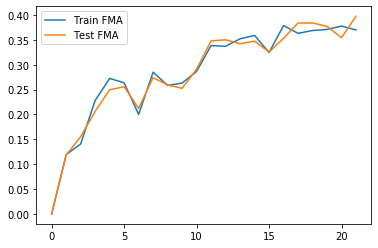

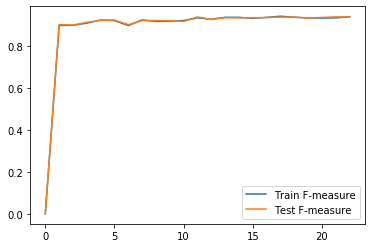

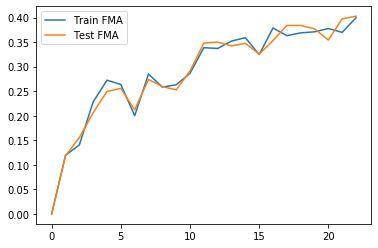

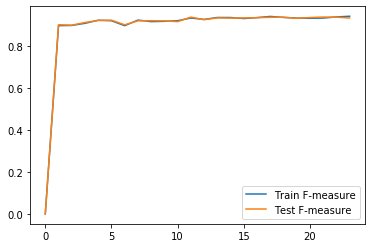

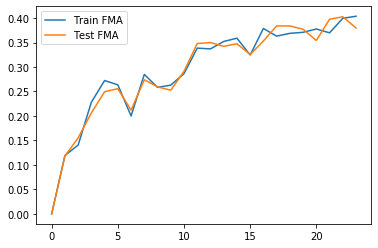

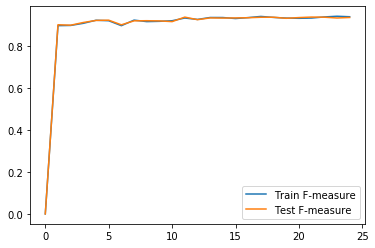

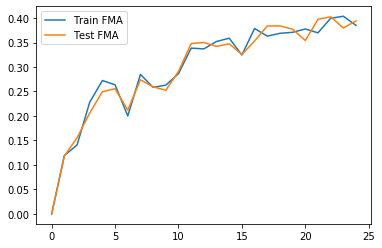

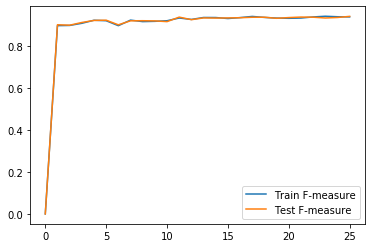

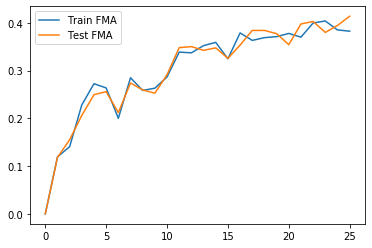

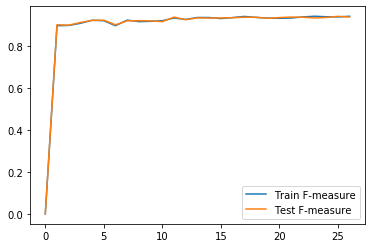

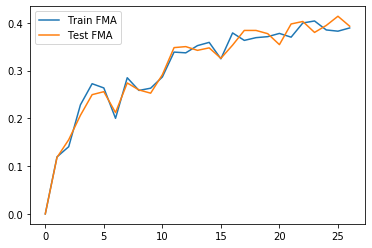

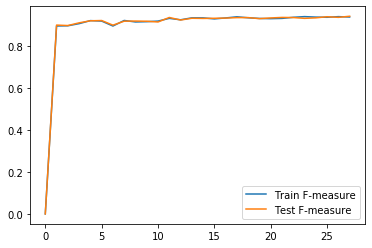

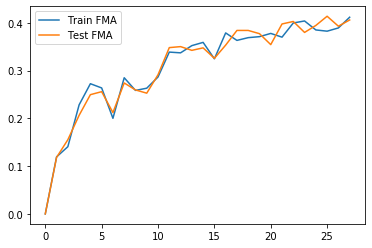

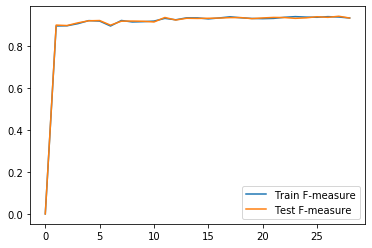

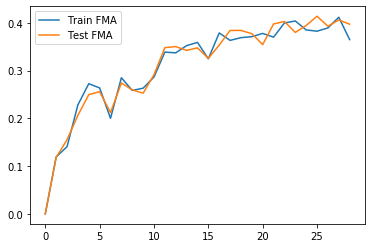

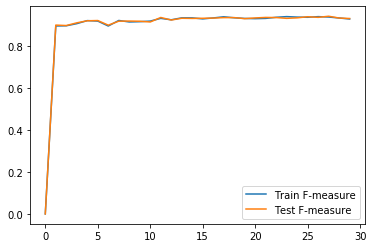

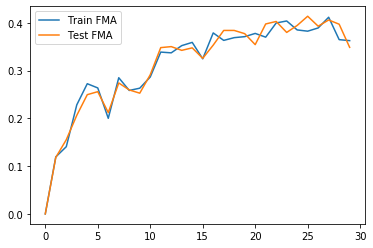

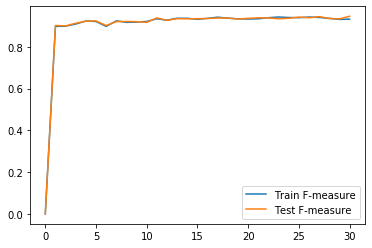

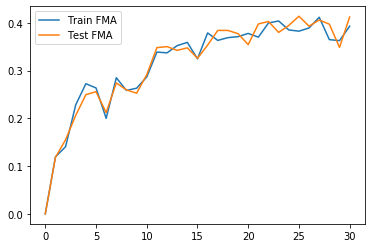

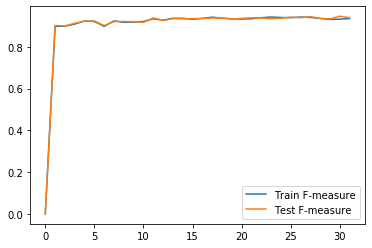

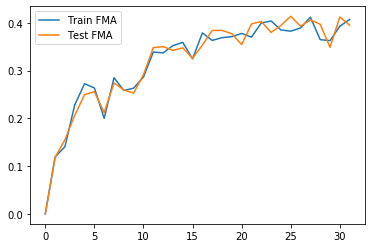

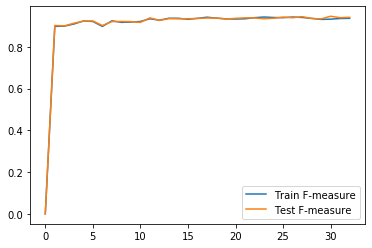

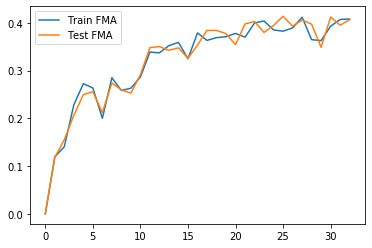

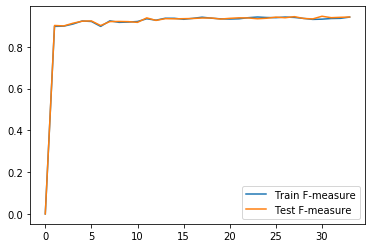

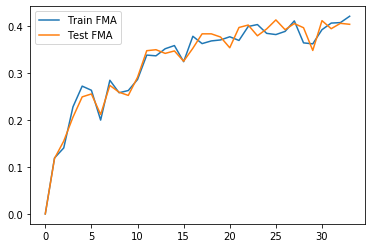

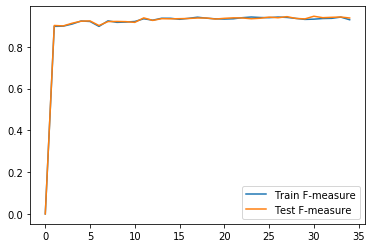

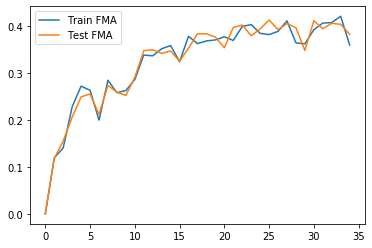

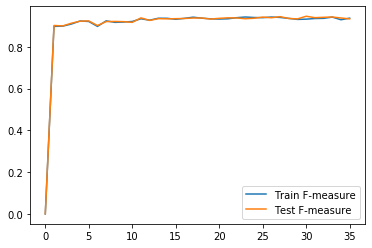

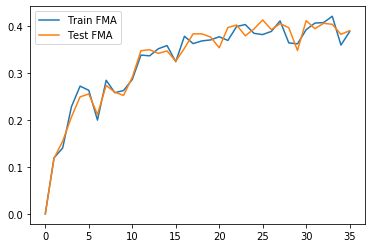

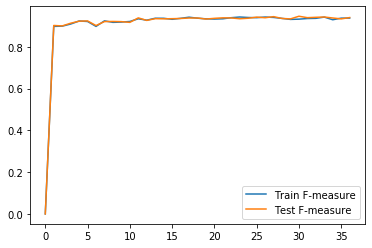

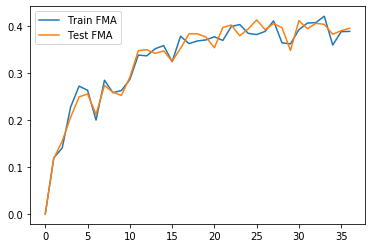

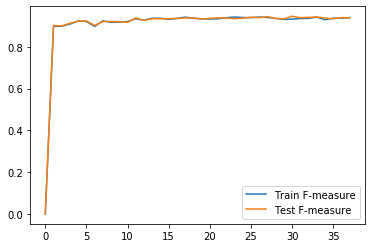

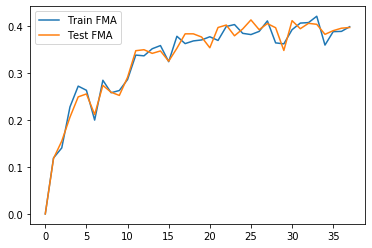

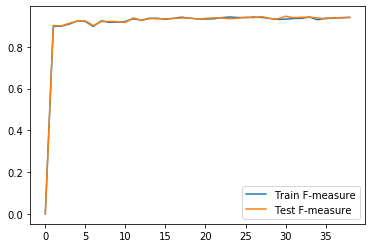

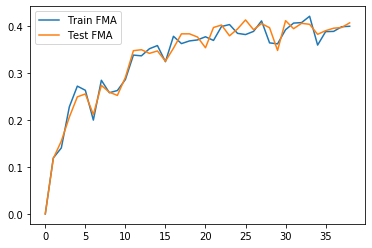

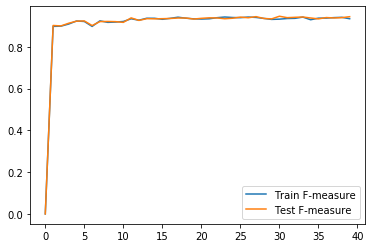

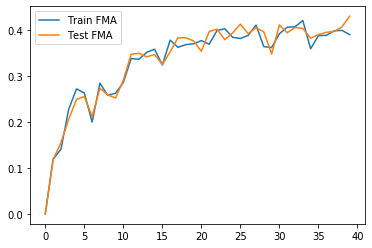

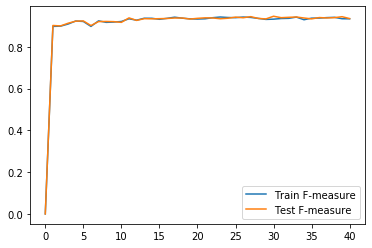

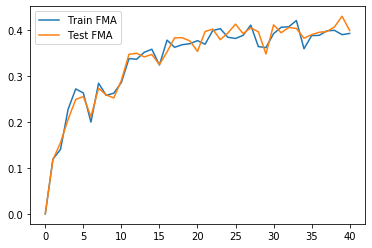

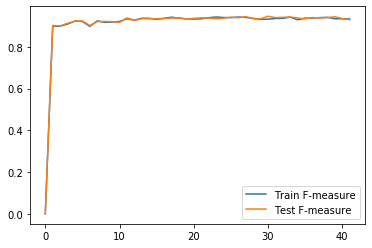

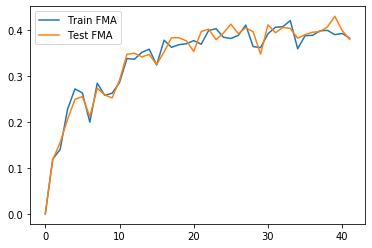

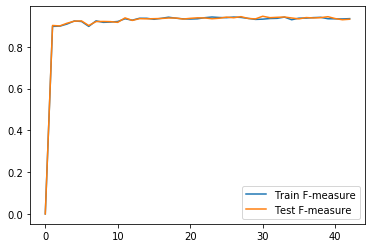

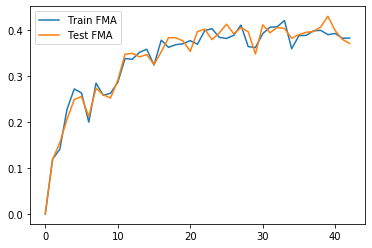

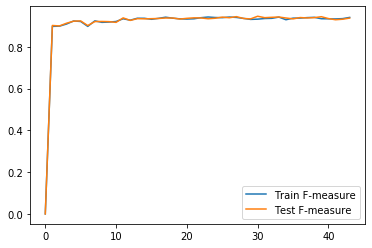

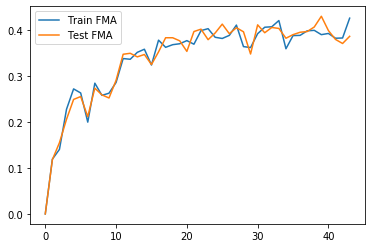

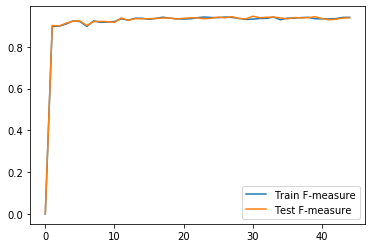

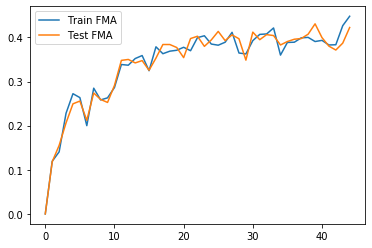

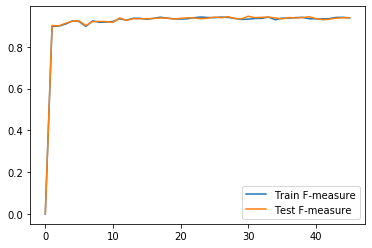

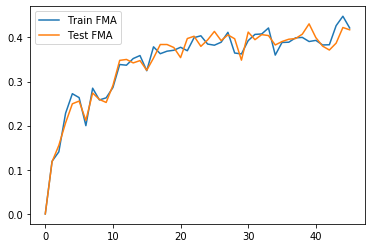

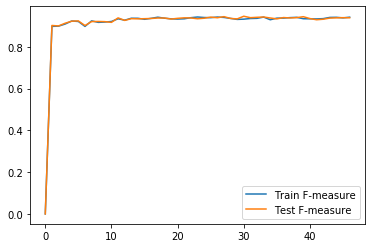

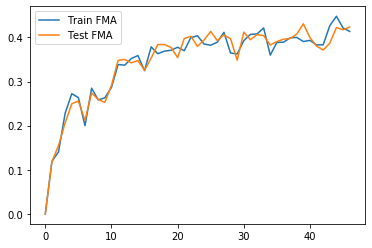

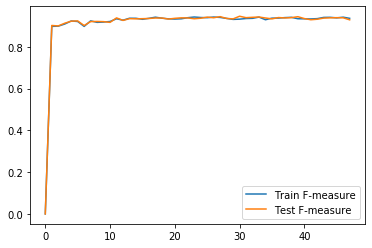

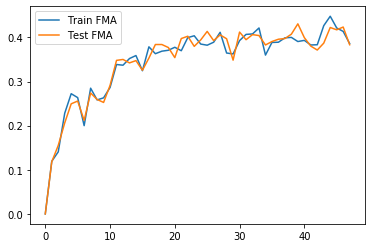

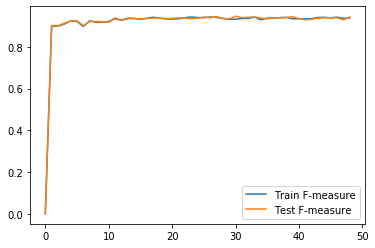

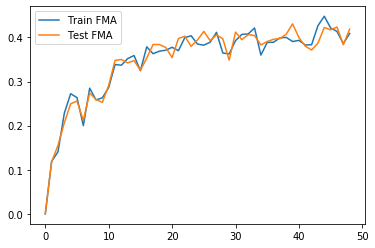

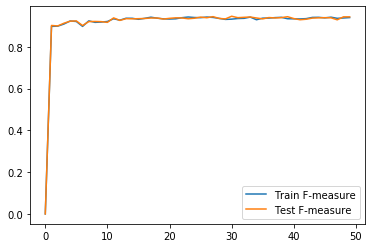

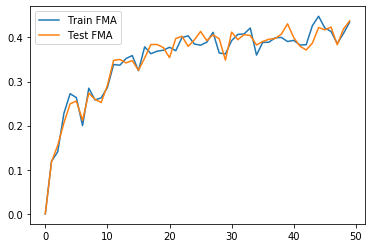

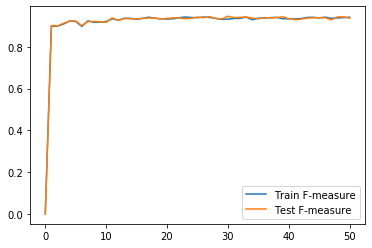

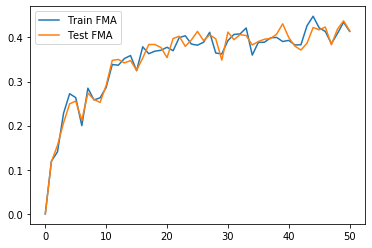

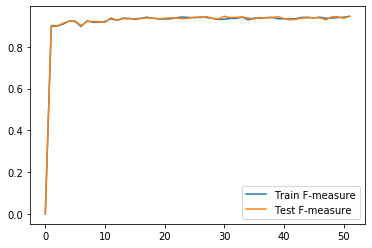

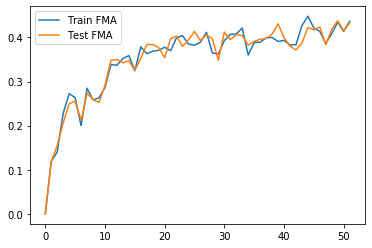

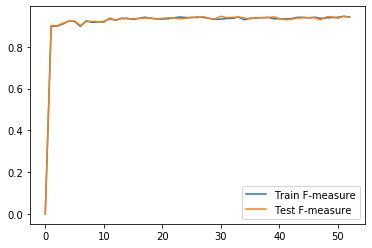

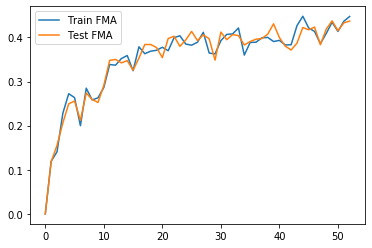

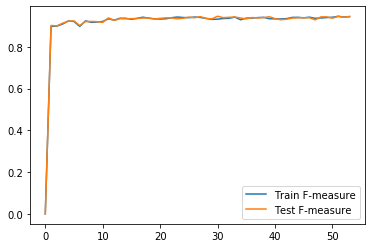

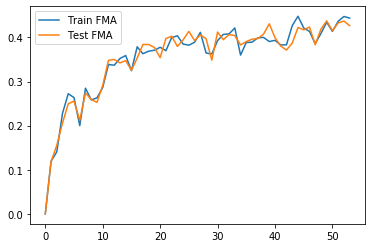

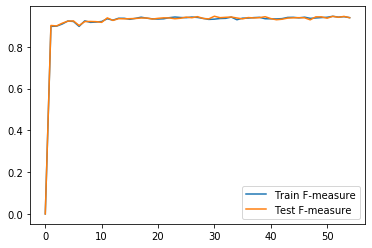

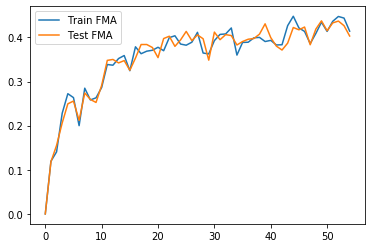

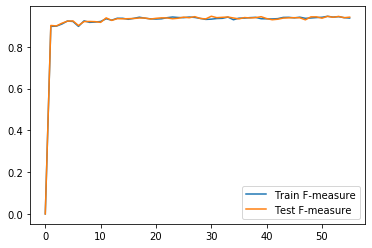

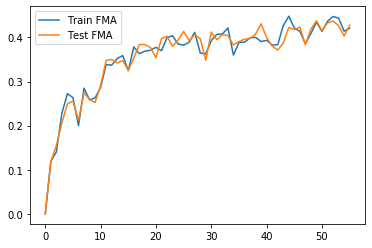

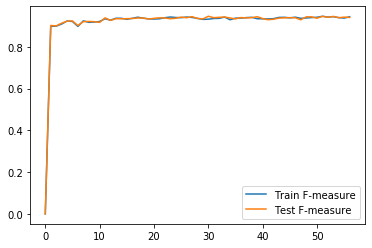

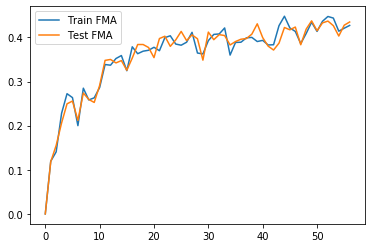

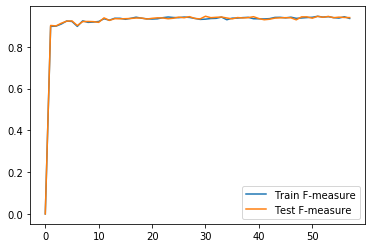

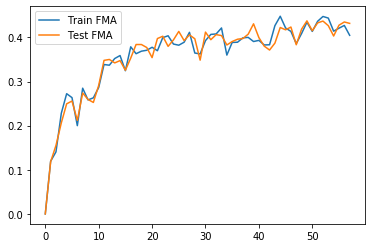

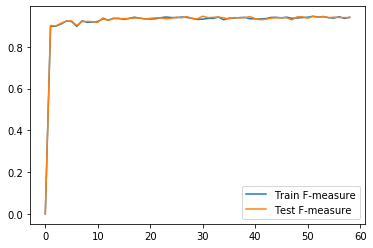

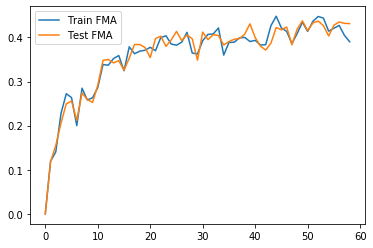

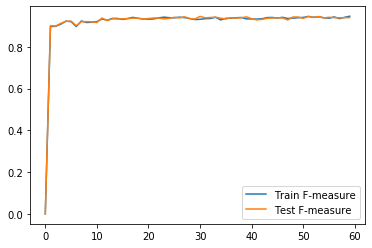

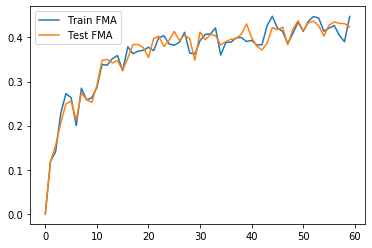

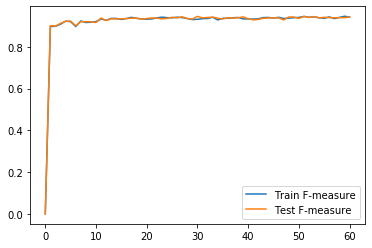

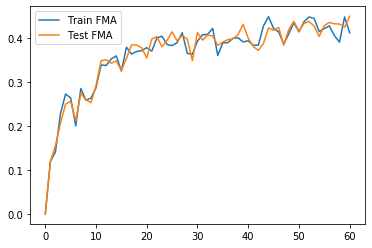

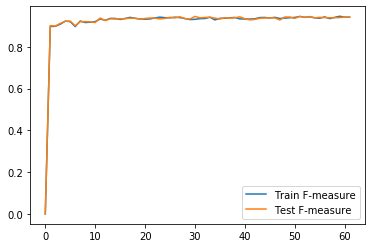

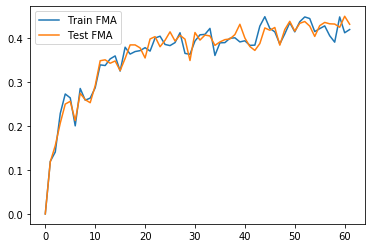

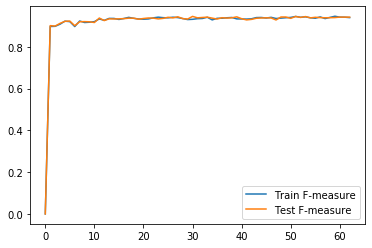

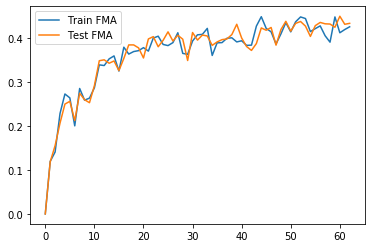

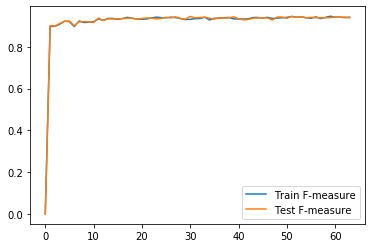

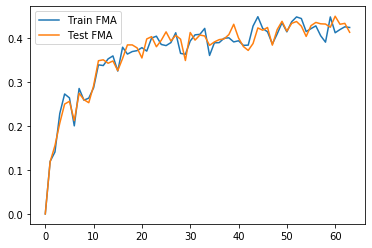

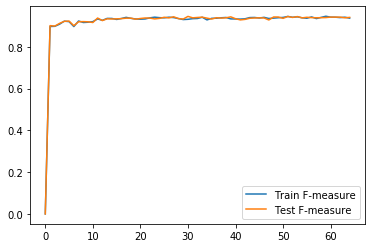

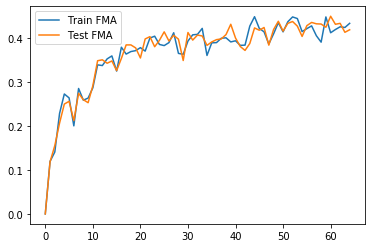

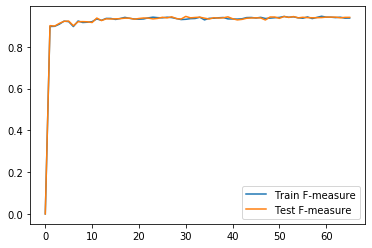

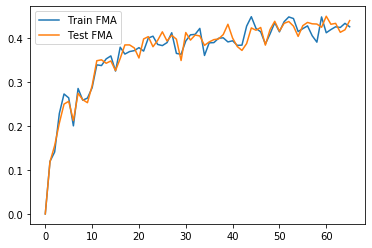

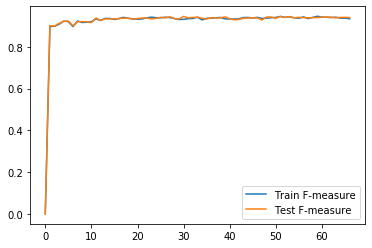

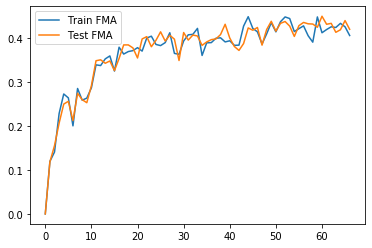

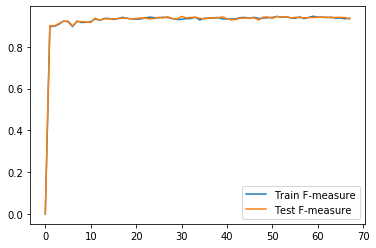

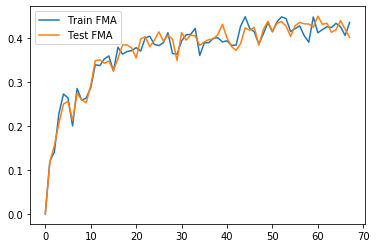

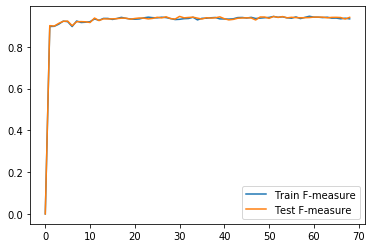

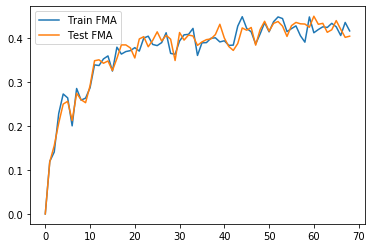

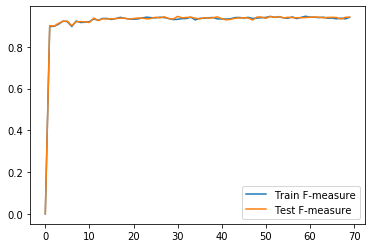

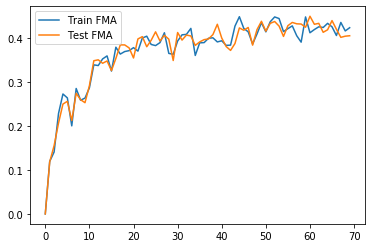

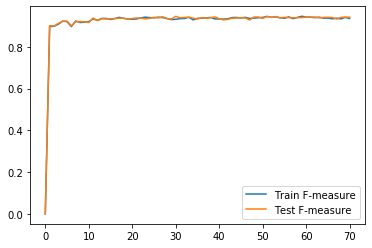

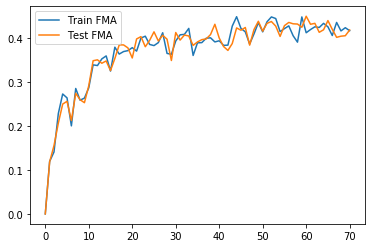

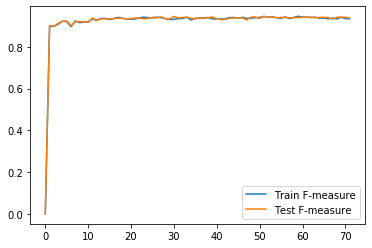

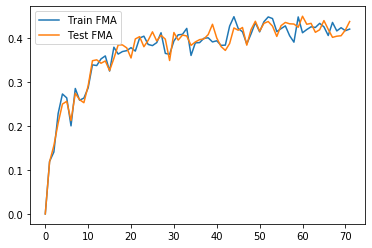

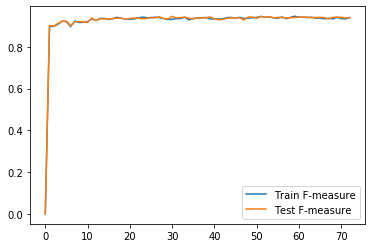

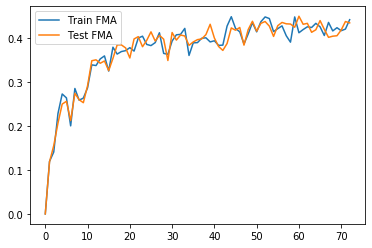

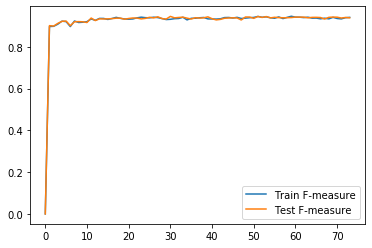

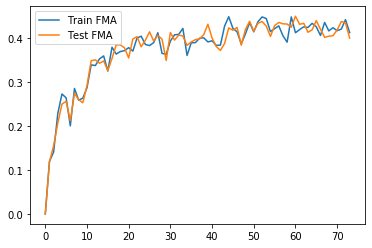

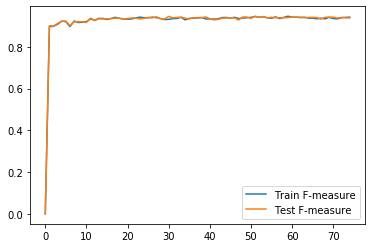

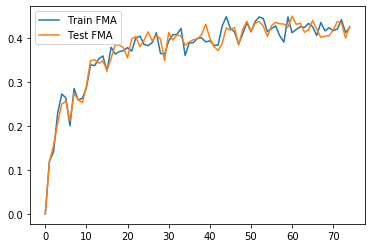

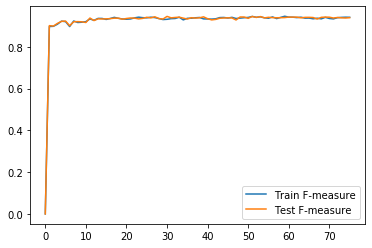

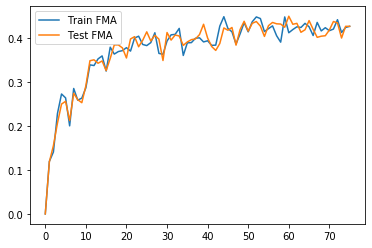

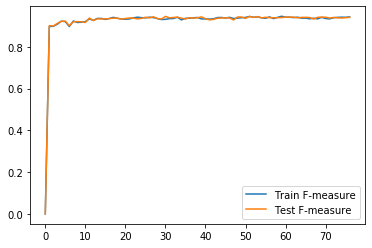

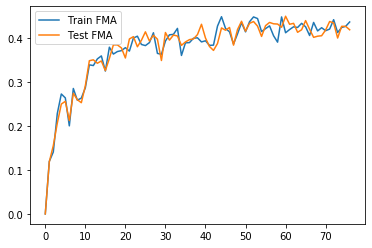

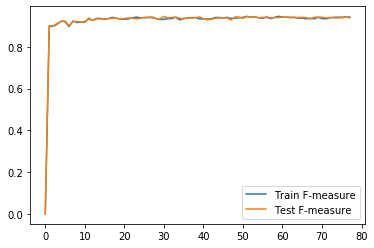

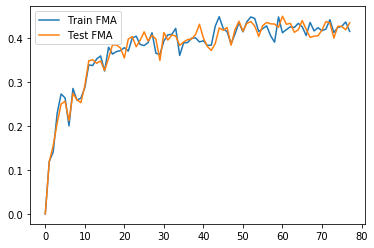

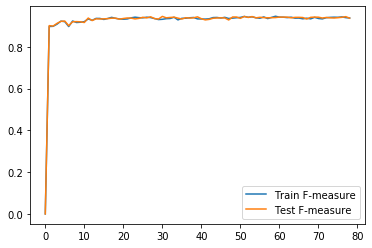

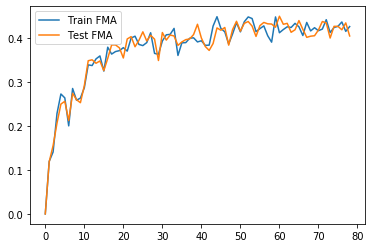

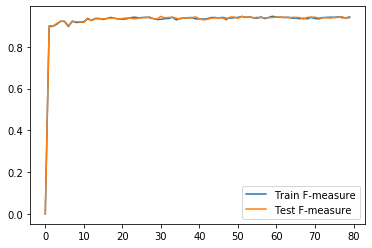

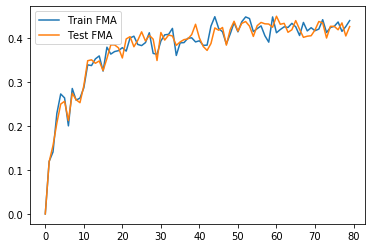

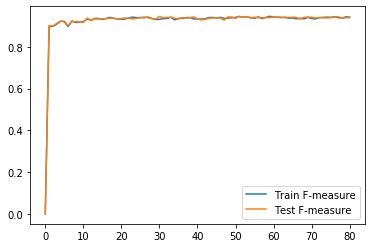

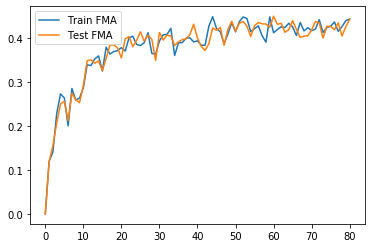

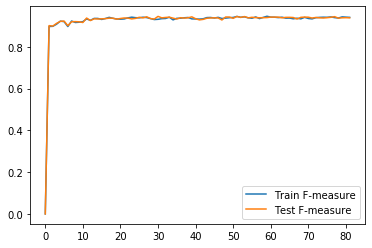

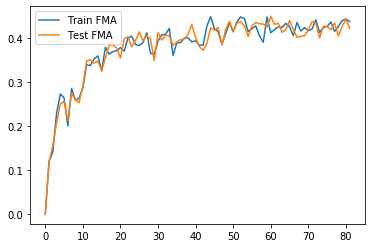

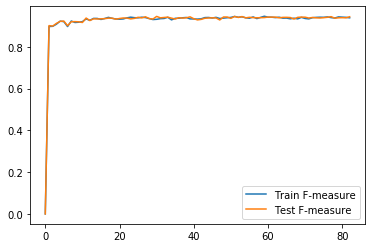

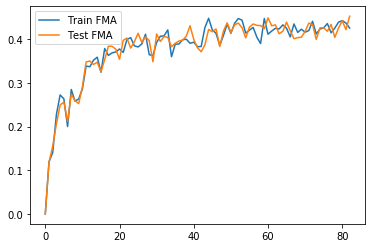

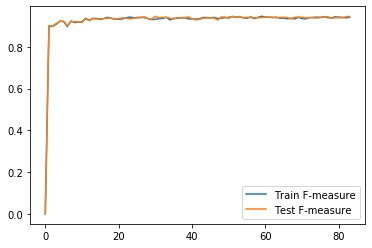

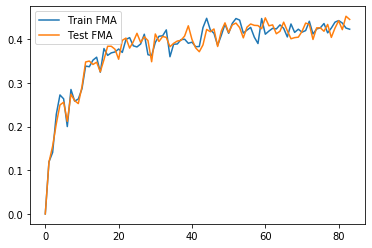

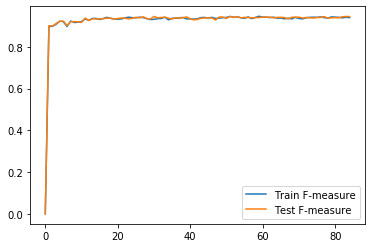

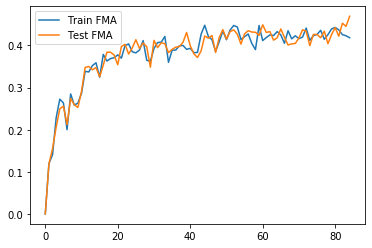

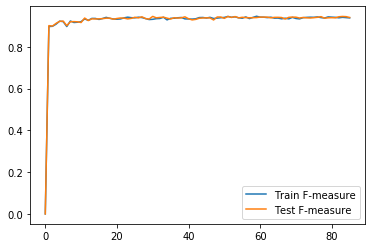

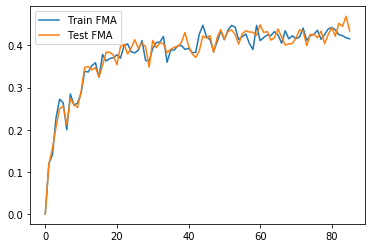

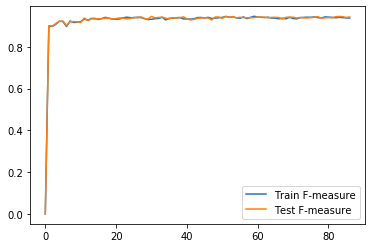

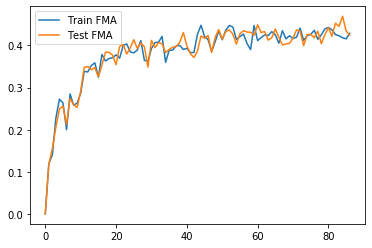

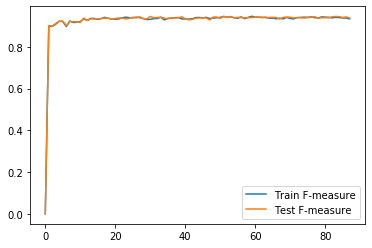

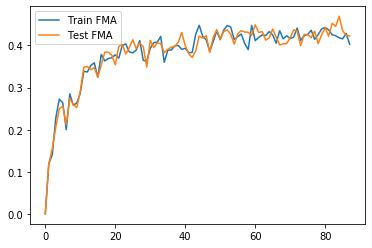

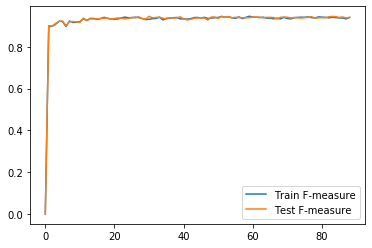

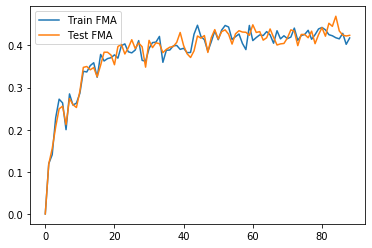

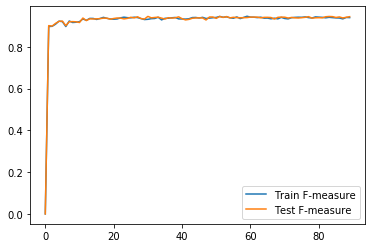

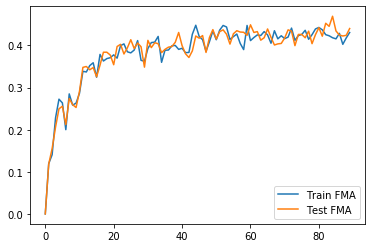

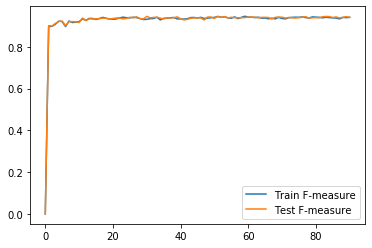

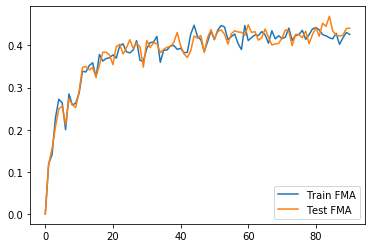

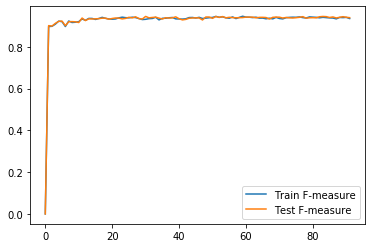

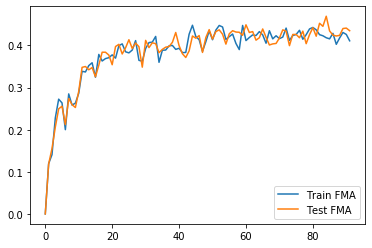

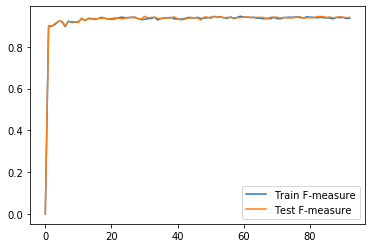

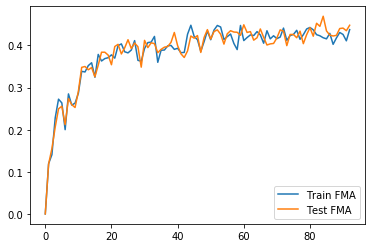

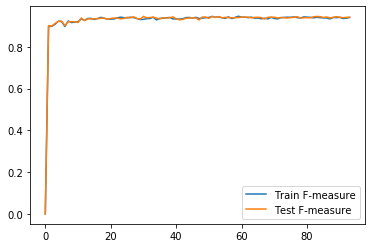

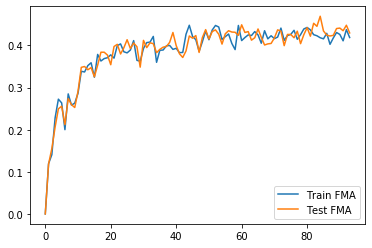

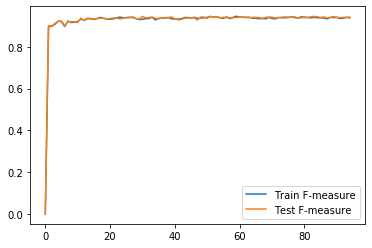

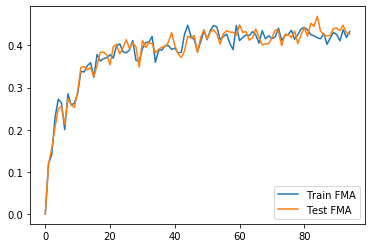

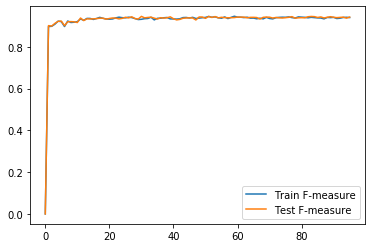

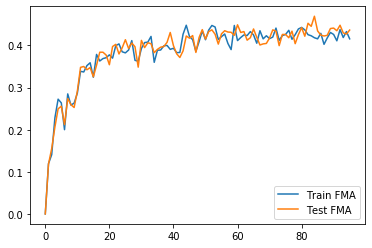

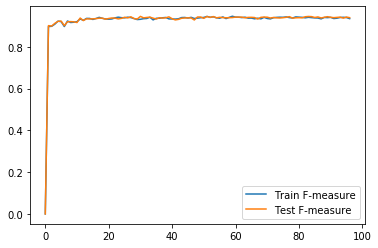

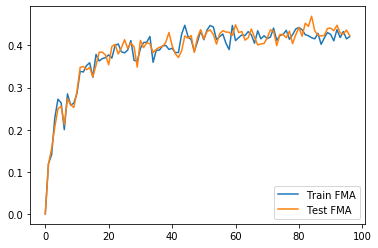

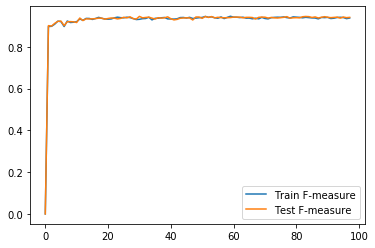

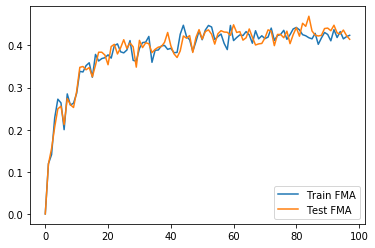

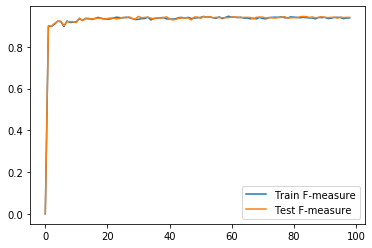

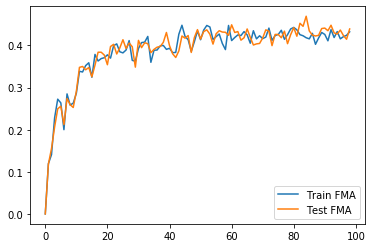

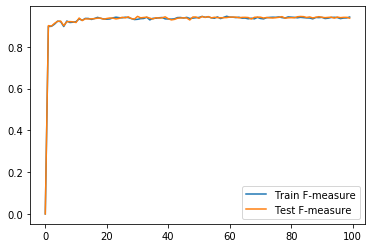

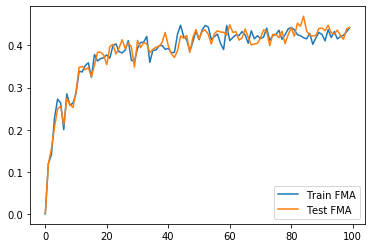

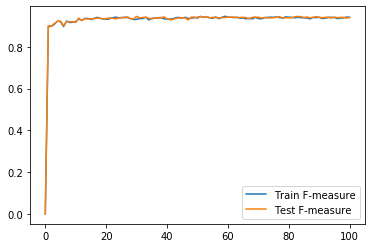

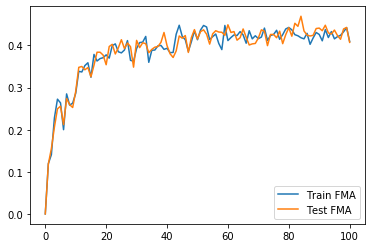

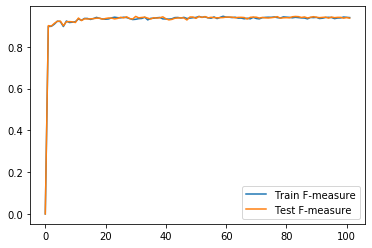

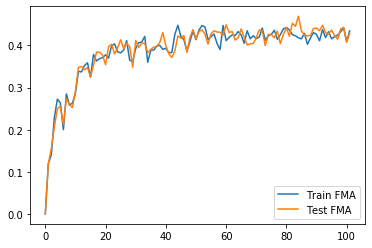

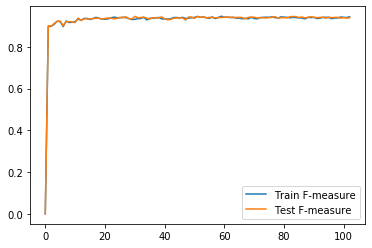

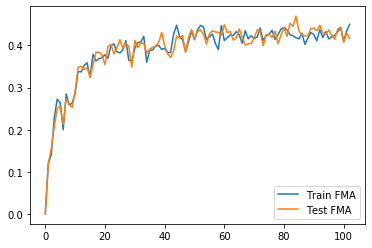

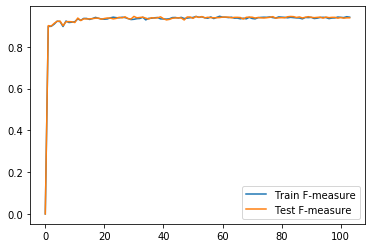

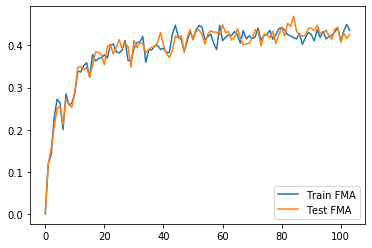

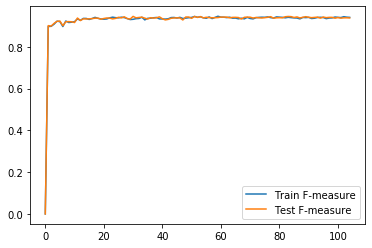

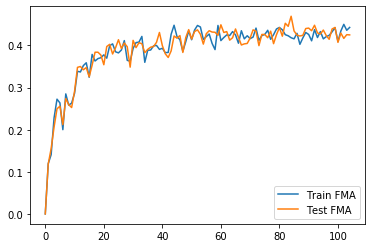

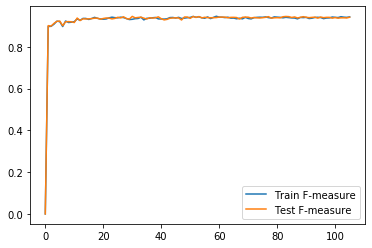

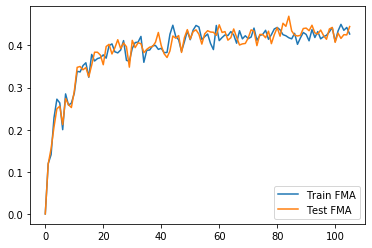

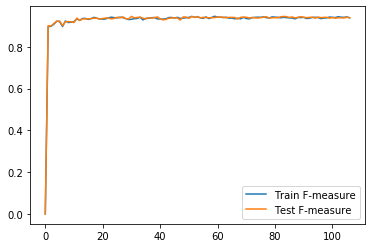

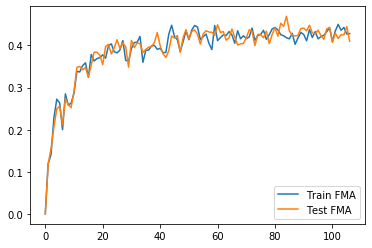

KeyboardInterrupt: 

In [19]:
step = 0
loss = 1
while loss > 0:
        model.train()
        step += 1
        batch, tgts = batch_gen(batch_size, train_dataset, device=device)
        optimizer.zero_grad()
        logits = model.forward(batch)
        loss = bce_loss(sigmoid(logits[:, :, 0])[tgts > -.1], tgts[tgts > -.1])
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        if step % 1000 == 1:
            exp_lr_scheduler(optimizer, step, init_lr=lr, decay_steps=2000, decay_rate=.9)
            with torch.no_grad():
                train_pr = []
                train_re = []
                train_fs = []
                test_pr = []
                test_re = []
                test_fs = []
                for _ in range(30):
                    optimizer.zero_grad()
                    batch, tgts = batch_gen(batch_size, train_dataset, device=device)               
                    predict = (model.forward(batch).cpu() > .5).int()[:, :, 0].numpy()
                    pr, re, fs = get_scores(tgts.cpu().numpy(), predict)
                    train_pr.extend(pr)
                    train_re.extend(re)
                    train_fs.extend(fs)

                    batch, tgts = batch_gen(batch_size, test_dataset, device=device)               
                    predict = (model.forward(batch).cpu() > .5).int()[:, :, 0].numpy()

                    pr, re, fs = get_scores(tgts.cpu().numpy(), predict)
                    test_pr.extend(pr)
                    test_re.extend(re)
                    test_fs.extend(fs)

                train_pr_avg.append(np.mean(train_pr))
                train_re_avg.append(np.mean(train_re))
                train_fs_avg.append(np.mean(train_fs))

                test_pr_avg.append(np.mean(test_pr))
                test_re_avg.append(np.mean(test_re))
                test_fs_avg.append(np.mean(test_fs))         
                train_fm_avg.append(np.mean(np.array(train_fs) > .99))
                test_fm_avg.append(np.mean(np.array(test_fs) > .99))

                plt.plot(train_fs_avg, label='Train F-measure')
                plt.plot(test_fs_avg, label='Test F-measure')
                plt.legend()
                plt.show()

                plt.plot(train_fm_avg, label='Train FMA')
                plt.plot(test_fm_avg, label='Test FMA')
                plt.legend()
                plt.show()

In [20]:
with open('GCN+SuperNode+external', 'wb') as f:
    pickle.dump([train_fs_avg, test_fs_avg, train_fm_avg, test_fm_avg], f)

In [ ]:
plt.plot(train_fs_avg[50:], label='Train F-measure')
plt.plot(test_fs_avg[50:], label='Test F-measure')
plt.legend()
plt.show()

plt.plot(train_fm_avg, label='Train FMA')
plt.plot(test_fm_avg, label='Test FMA')
plt.legend()
plt.show()